In [249]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Řešení nevazké a vazké 1D burgersovy rovnice
V této úloze vyřešíme dvě úlohy. Volbu úlohy lze nastavit pomocí parametru `TYPE` na "inviscid" nebo "viscous".

**Nevazká 1D Burgersova úloha:**
\begin{align*}
        \frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}&=0,\:\:x\in\langle -1,1\rangle,\:t\in\langle 0,1\rangle, \\
    u(x,0)&=x+3,\\
    u(-1,t)&=\frac{-1+3}{t+1},\\
    u(1,t)&=\frac{1+3}{t+1}.
\end{align*}
Analytické řešení této úlohy je 
\begin{equation} u(x,t)=\frac{x+3}{t+1}. \end{equation}

**Vazká 1D Burgersova úloha:**
\begin{align*}
    \frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}-\frac{\partial^2u}{\partial x^2}&=0,\:\:x\in\langle -1,1\rangle,\:t\in\langle 0,1\rangle, \\
    u(x,0)&=\frac{2}{1+\mathrm{e}^x},\\
    u(-1,t)&=\frac{2}{1+\mathrm{e}^{-1-t}},\\
    u(1,t)&=\frac{2}{1+\mathrm{e}^{1-t}}.
\end{align*}
Analytické řešení této úlohy je 
\begin{equation} u(x,t)=\frac{2}{1+\mathrm{e}^{x-t}}. \end{equation}

Použijeme NN s 5 skrytými vrstvami s aktivační funkcí $tanh()$ s 20 neurony v každé vrstvě.
Trénování provedeme na 1000 rovnoměrně rozložených bodech uvnitř oblasti $(-1,1)\times(0,1)$ a 50 bodech na hranici oblasti.
Trénování provedeme ve 4000 epochách.
Využijeme optimalizátor Adam s learning rate $5\cdot 10^{-3}$ v prvních 3950 epochách a optimalizátor LBFGS s learning rate $10^{-2}$, maximálním počtem iterací v optimalizačním kroku $20$ a update history size $10$ na posledních 50 epoch.
Testování provedeme na 10000 náhodně rozložených bodech vygenerovaných metodou LHS.

Proces definice, učení a testování neuronové sítě je rozdělen do několika kroků:

**Krok 1:**
Definujeme architekturu neuronové sítě.
Vytvoříme pomocné funkce:
- `generate_inner_train_data()` pro generování trénovacích bodů uvnitř oblasti,
- `generate_boundaries()` pro generování trénovacích bodů na hranici oblasti,
- `plot_boundaries()` pro vykreslení trénovacích bodů,
- `compute_derivatives_2d()` pro výpočet derivací,
- `exact_solution_inviscid()` a `exact_solution_viscous()` pro výpočet analytického řešení,
- `enerate_test_data_lhs()` pro vygenerování testovacích dat metodou LHS.

**Krok 2:**
Definujeme funkce pro výpočet ztráty a funkce closure pro použití optimalizátoru LBFGS:
- `compute_loss_inviscid()` a `compute_loss_viscous()` pro výpočet ztrátové funkce,
- `closure_inviscid()` a `closure_viscous()` pro použití optimalizátoru LBFGS

**Krok 3:**
Vygenerujeme trénovací data, inicializujeme model a optimalizátor Adam.

**Krok 4:**
Spustíme trénovací smyčku na 4000 epochách se změnou optimalizátoru na LBFGS po 3950 epochách.
Vykreslíme graf znázorňující závislost ztráty na počtu epoch.

**Krok 5:**
Vykreslíme aproximace řešení pomocí NN s využitím interpolace.
Vykreslíme řezy přesného a aproximovaného řešení v t=0,25; t=0,5; t=0,75.

**Krok 6:**
Výpočteme celkovou relativní chybu aproximace řešení pomocí NN a vykreslíme bodovou relativní chybu aproximace řešení pomocí NN.

In [250]:
# Určení typu řešené úlohy - nevazká nebo vazká 1D Burgersova rovnice
TYPE = "viscous" # "inviscid" nebo "viscous"

In [251]:
# Krok 1.1: Definice modelu neuronové sítě 
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Vstup je 2D, proto 2 vstupy (x,t)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(20, 20)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(20, 20)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(20, 20)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(20, 20)
        self.tanh5 = nn.Tanh()
        self.fc6 = nn.Linear(20, 1)  # Výstup je skalár u(x,t)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.tanh2(x)
        x = self.fc3(x)
        x = self.tanh3(x)
        x = self.fc4(x)
        x = self.tanh4(x)
        x = self.fc5(x)
        x = self.tanh5(x)
        x = self.fc6(x)
        return x

In [252]:
# Krok 1.2: Funkce pro generování rovnoměrně rozložených trénovacích dat
def generate_inner_train_data(no_points): # Body uvnitř oblasti
    t = torch.linspace(0, 1, int(torch.sqrt(torch.tensor(no_points)))) 
    x = torch.linspace(-1, 1, int(torch.sqrt(torch.tensor(no_points)))) 
    T, X = torch.meshgrid(t, x)

    t = T.reshape(-1, 1)
    x = X.reshape(-1, 1)
    
    points_in = (t < 1 - 1e-3) & (t > 1e-3) & (torch.abs(x) < 1 - 1e-3)

    t_train = t[points_in].view(-1, 1)
    x_train = x[points_in].view(-1, 1)

    return (t_train, x_train)

def generate_boundaries(no_points): # Body na hranici
    t_bottom = torch.linspace(0,1, no_points).view(-1, 1)
    x_bottom = -1*torch.ones_like(t_bottom)
    x_left = torch.linspace(-1, 1, no_points).view(-1, 1)
    t_left = torch.zeros_like(x_left)
    t_top = torch.linspace(0, 1, no_points).view(-1, 1)
    x_top = torch.ones_like(t_top)

    return (t_bottom, x_bottom, t_top, x_top, t_left, x_left)

In [253]:
# Krok 1.2: Funkce pro vykreslení trénovacích bodů
def plot_boundaries(t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left):
    plt.figure(figsize=(12, 6))
    plt.scatter(t_bottom.numpy(), x_bottom.numpy(), label="Bottom",s=5, color='blue')
    plt.scatter(t_top.numpy(), x_top.numpy(), label="Top",s=5, color='green')
    plt.scatter(t_left.numpy(), x_left.numpy(), label="Left",s=5, color='red')
    plt.scatter(t_train.numpy(), x_train.numpy(), label="Trénovací data",s=10, color='yellow')
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.title("Hranice")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()
    return

In [254]:
# Krok 1.3: Funkce pro výpočet derivací
def compute_derivatives_2d(model, x, y): # Výpočet derivací pomocí funkce autograd z knihovny PyTorch
    inputs = torch.hstack((x,y)).requires_grad_(True)
    u = model(inputs)
    
    # První derivace
    u_x = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 0:1]  # du/dx
    u_y = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 1:2]  # du/dy
    
    # Druhé derivace
    u_xx = grad(u_x, inputs, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]  # d²u/dx²
    u_yy = grad(u_y, inputs, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]  # d²u/dy²
    
    return (u, u_x, u_y, u_xx, u_yy)

In [255]:
# Krok 1.4: Funkce pro výpočet analytického řešení
def exact_solution_inviscid(t_data, x_data):
    u = (1*x_data + 3*torch.ones_like(x_data))/(t_data + torch.ones_like(t_data))
    return u

def exact_solution_viscous(t_data, x_data):
    u = 2*torch.ones_like(t_data)/(torch.ones_like(t_data)+torch.exp(x_data-t_data))
    return u

In [258]:
# Krok 1.5: Funkce pro vygenerování testovacích dat v oblasti (i na její hranici)
def generate_test_data_lhs(no_points):
    # Body uvnitř a na hranici oblasti
    no_inside_points = int(no_points * 0.97)
    no_boundary_points = no_points - no_inside_points

    # Funkce pro generování pomocí LHS
    def latin_hypercube_sampling(num_samples, dim):
        # Mřížka intervalů
        grid = torch.linspace(0, 1, num_samples + 1)[:-1].unsqueeze(1)
        grid = grid + (torch.rand(num_samples, dim) / num_samples)
        for d in range(dim):
            grid[:, d] = grid[torch.randperm(num_samples), d]
        return grid

    # Vnitřní body
    lhs_inside = latin_hypercube_sampling(no_inside_points, 2)
    x_inside = lhs_inside[:, 0:1]
    y_inside = lhs_inside * 2 - 1
    y_inside = y_inside[:, 1:2]

    # Body na hranici
    lhs_boundary = latin_hypercube_sampling(no_boundary_points, 1)
    side_assignments = torch.randint(0, 4, (no_boundary_points,)) 
    x_boundary = torch.zeros(no_boundary_points, 1)
    y_boundary = torch.zeros(no_boundary_points, 1)

    # Přiřazení bodů na hranice: 0 -> horní, 1 -> dolní, 2 -> levá, 3 -> pravá
    x_boundary[side_assignments == 0] = lhs_boundary[side_assignments == 0]
    y_boundary[side_assignments == 0] = 1

    x_boundary[side_assignments == 1] = lhs_boundary[side_assignments == 1]
    y_boundary[side_assignments == 1] = -1

    x_boundary[side_assignments == 2] = 0
    y_boundary[side_assignments == 2] = lhs_boundary[side_assignments == 2] *2 -1

    x_boundary[side_assignments == 3] = 1
    y_boundary[side_assignments == 3] = lhs_boundary[side_assignments == 3]

    # Spojení bodů
    x_test = torch.cat((x_inside, x_boundary), dim=0)
    y_test = torch.cat((y_inside, y_boundary), dim=0)

    return (x_test, y_test)

In [256]:
# Krok 2.1: Definice ztrátové funkce
def compute_loss_inviscid(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left):
    # PDR ztráta
    u_train, u_t_train, u_x_train, _, _ = compute_derivatives_2d(model, t_train, x_train) # Výpočet derivací
    pde_loss = torch.mean((-(u_t_train + u_train * u_x_train))**2)
    
    # Ztráta na hranici
    u_left = model(torch.cat([t_left, x_left], dim=1))
    left_loss = torch.mean((u_left - (x_left+3*torch.ones_like(x_left)))**2)

    u_top = model(torch.cat([t_top, x_top], dim=1))
    top_loss = torch.mean((u_top - (1*torch.ones_like(t_top)+3*torch.ones_like(t_top))/(1*t_top+1*torch.ones_like(t_top)))**2)

    u_bottom = model(torch.cat([t_bottom, x_bottom], dim=1))
    bottom_loss = torch.mean((u_bottom - (-1*torch.ones_like(t_top)+3*torch.ones_like(t_top))/(1*t_top+1*torch.ones_like(t_top)))**2)

    # Celková ztráta
    total_loss = pde_loss + left_loss + top_loss + bottom_loss
    return total_loss

def compute_loss_viscous(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left):
    # PDR ztráta
    u_train, u_t_train, u_x_train, _, u_xx_train = compute_derivatives_2d(model, t_train, x_train) # Výpočet derivací
    pde_loss = torch.mean((-(u_t_train + u_train * u_x_train - u_xx_train))**2)
    
    # Ztráta na hranici
    u_left = model(torch.cat([t_left, x_left], dim=1))
    left_loss = torch.mean((u_left - 2*torch.ones_like(x_left)/(torch.ones_like(x_left)+torch.exp(x_left)))**2)

    u_top = model(torch.cat([t_top, x_top], dim=1))
    top_loss = torch.mean((u_top - 2*torch.ones_like(t_top)/(torch.ones_like(t_top)+torch.exp(torch.ones_like(t_top) - t_top)))**2)

    u_bottom = model(torch.cat([t_bottom, x_bottom], dim=1))
    bottom_loss = torch.mean((u_bottom - 2*torch.ones_like(t_bottom)/(torch.ones_like(t_bottom)+torch.exp(-torch.ones_like(t_bottom) - t_bottom)))**2)

    # Celková ztráta
    total_loss = pde_loss + left_loss + top_loss + bottom_loss
    return total_loss

In [257]:
# Krok 2.2: Funkce closure pro použití optimalizátoru LBFGS
def closure_inviscid():
    optimizer.zero_grad()

    loss = compute_loss_inviscid(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left)

    loss.backward(retain_graph=True)
    return loss

def closure_viscous():
    optimizer.zero_grad()

    loss = compute_loss_viscous(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left)

    loss.backward(retain_graph=True)
    return loss

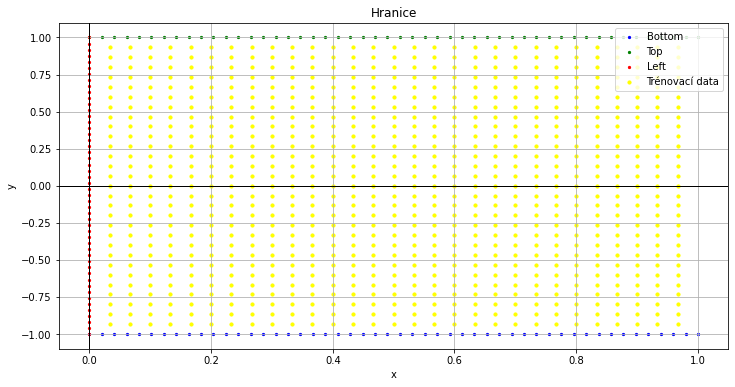

In [ ]:
# Krok 3.1: Vygenerování trénovacích dat
t_train, x_train = generate_inner_train_data(1000) # Body uvnitř oblasti
t_bottom, x_bottom, t_top, x_top, t_left, x_left = generate_boundaries(50) # Body na hranici oblasti

plot_boundaries(t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left) # Vykreslení trénovacích dat

In [260]:
# Krok 3.2: Inicializace modelu a optimalizátoru
model = MyModel()
optimizer = optim.Adam(model.parameters(), lr=5e-3) 

In [261]:
# Krok 4.1: Trénovací smyčka
loss_values = [] # Seznam pro ukládání ztráty v každé epoše
epochs = 4000
best_loss = float('inf')
best_epoch = -1 
best_model_state_dict = None
for epoch in range(epochs):
    if epoch <= epochs-50:
        optimizer.zero_grad()
    
        # Výpočet ztráty
        if TYPE == "inviscid":
            loss = compute_loss_inviscid(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left)
        elif TYPE == "viscous":
            loss = compute_loss_viscous(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left)

        loss.backward() # Backward pass
        optimizer.step() # Optimalizace
    else:
        if TYPE == "inviscid":
            loss = optimizer.step(closure_inviscid)
        elif TYPE == "viscous":
            loss = optimizer.step(closure_viscous)

    if epoch == epochs-50:
        print(f"Změna optimalizátoru v epoše {epoch + 1}. Použití NN s nejlepší ztrátou {best_loss:.6f}")
        model.load_state_dict(best_model_state_dict)
        optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20, history_size=10)

    loss_values.append(loss.detach().numpy())

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
        best_model_state_dict = model.state_dict()

    if (epoch + 1) % 100 == 0:
        print(f'Epocha {epoch+1}/{epochs}, Ztráta: {loss.item()}')

Epocha 100/4000, Ztráta: 0.0008220438612625003
Epocha 200/4000, Ztráta: 7.290182111319155e-05
Epocha 300/4000, Ztráta: 3.349491089466028e-05
Epocha 400/4000, Ztráta: 2.3969554604263976e-05
Epocha 500/4000, Ztráta: 2.0045963537995704e-05
Epocha 600/4000, Ztráta: 1.747365422488656e-05
Epocha 700/4000, Ztráta: 1.545003760838881e-05
Epocha 800/4000, Ztráta: 1.3746646800427698e-05
Epocha 900/4000, Ztráta: 1.2263270946277771e-05
Epocha 1000/4000, Ztráta: 1.0949575880658813e-05
Epocha 1100/4000, Ztráta: 9.778497769730166e-06
Epocha 1200/4000, Ztráta: 8.733372851565946e-06
Epocha 1300/4000, Ztráta: 7.802006621204782e-06
Epocha 1400/4000, Ztráta: 6.973781637498178e-06
Epocha 1500/4000, Ztráta: 6.238411060621729e-06
Epocha 1600/4000, Ztráta: 5.586451152339578e-06
Epocha 1700/4000, Ztráta: 5.008363132219529e-06
Epocha 1800/4000, Ztráta: 4.495432222029194e-06
Epocha 1900/4000, Ztráta: 4.039551640744321e-06
Epocha 2000/4000, Ztráta: 3.633439291661489e-06
Epocha 2100/4000, Ztráta: 6.431995643652044e

Nejlepší epocha 3999, Ztráta: 9.832388059294317e-07


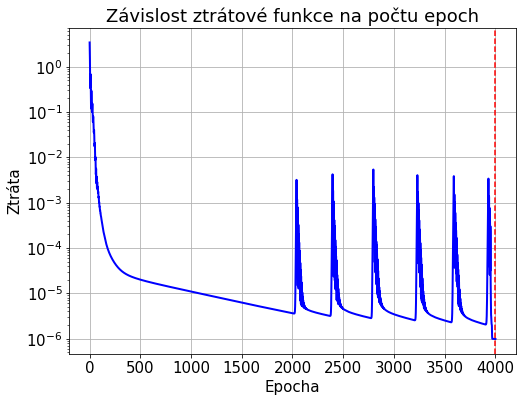

In [262]:
# Krok 4.2: Graf znázorňující závislost ztráty na počtu epoch
best_epoch = min(loss_values)
best_epoch_idx = loss_values.index(best_epoch)
print(f'Nejlepší epocha {best_epoch_idx}, Ztráta: {best_epoch}')

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_values, color='blue', linewidth=2)
plt.axvline(best_epoch_idx, color='r', linestyle='--', label='Nejlepší epocha')
plt.yscale('log')
plt.title('Závislost ztrátové funkce na počtu epoch', fontsize=18)
plt.xlabel('Epocha', fontsize=15)
plt.ylabel('Ztráta', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.show()

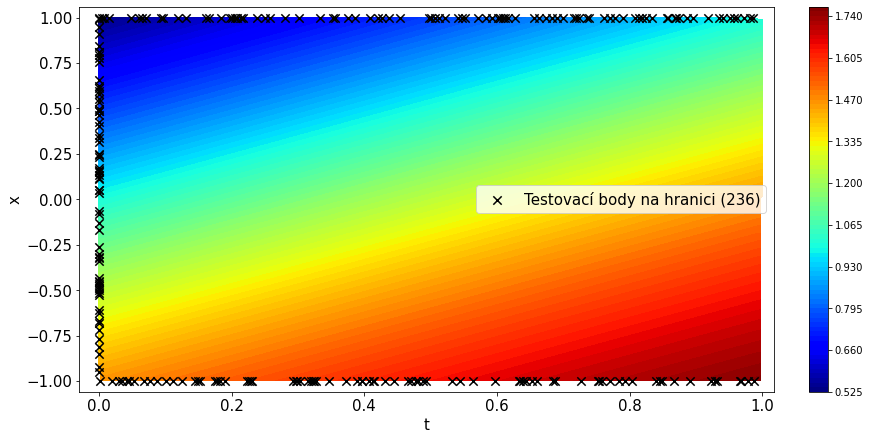

In [264]:
# Krok 5.1: Vykreslení aproximace NN řešení zadané úlohy ve 2D grafu s interpolací
t_test, x_test = generate_test_data_lhs(10000)
model.load_state_dict(best_model_state_dict)
with torch.no_grad():
    inputs = torch.cat([t_test, x_test], dim=1)
    u_pred = model(inputs) 

# Interpolace
fig, axes = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)

t = t_test.detach().cpu().numpy().squeeze()
x = x_test.detach().cpu().numpy().squeeze()
z = u_pred.detach().cpu().numpy().squeeze()

grid_t, grid_x = np.linspace(0, 1, 500), np.linspace(-1, 1, 500)
grid_t, grid_x = np.meshgrid(grid_t, grid_x)
grid_z = griddata((t, x), z, (grid_t, grid_x), method="linear")

# Vykreslení
ax = axes
im = ax.contourf(grid_t, grid_x, grid_z, levels=100, cmap="jet", vmin=None, vmax=None)
cbar = fig.colorbar(im, ax=ax, orientation="vertical")
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("x", fontsize=15)
# Vykreslení bodů na hranici
boundary_mask = (x == -1) | (x == 1) | (t == 0)
t_boundary = t[boundary_mask]
x_boundary = x[boundary_mask]
no_bound_points = len(t_boundary)
ax.scatter(t_boundary, x_boundary, color="black", s=70, label=f"Testovací body na hranici ({no_bound_points})", marker="x")

ax.legend(fontsize=15)
x_padding = 0.03 * (x_boundary.max() - x_boundary.min())  # Přidání okrajů
t_padding = 0.03 * (t_boundary.max() - t_boundary.min())
ax.set_xlim(t_boundary.min() - t_padding, t_boundary.max() + t_padding)
ax.set_ylim(x_boundary.min() - x_padding, x_boundary.max() + x_padding)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [265]:
# Krok 5.2: Definice funkce pro vykreslení řezů aproximace řešení pomocí NN a přesného řešení
def plot_solution_cut_with_exact(t_fixed, t_test, x_test, u_pred):
    t = t_test.detach().cpu().numpy().squeeze()
    x = x_test.detach().cpu().numpy().squeeze()
    z = u_pred.detach().cpu().numpy().squeeze()

    # Body poblíž řezu
    tolerance = 1e-3
    mask = np.abs(t - t_fixed) < tolerance
    x_filtered = x[mask]
    z_filtered = z[mask]

    # Interpolace
    x_interp = np.linspace(x_filtered.min(), x_filtered.max(), 500)
    z_interp = griddata(x_filtered, z_filtered, x_interp, method="linear")

    # Přesné řešení
    t_fixed_tensor = torch.full((500, 1), t_fixed)
    x_interp_tensor = torch.tensor(x_interp, dtype=torch.float32).view(-1, 1)
    if TYPE == "inviscid":
        exact_z = exact_solution_inviscid(t_fixed_tensor, x_interp_tensor)
    elif TYPE == "viscous":
        exact_z = exact_solution_viscous(t_fixed_tensor, x_interp_tensor)
    else:
        raise ValueError("Invalid TYPE. Use 'inviscid' or 'viscous'.")
    exact_z = exact_z.detach().cpu().numpy().squeeze()

    # Vykreslení predikcí a přesného řešení
    plt.figure(figsize=(12, 12))
    plt.plot(x_interp, exact_z, label="Analytické řešení", color="blue", linewidth=5)
    plt.plot(x_interp, z_interp, label=f"Predikce NN (t = {t_fixed:.3f})", color="red",linestyle="--", linewidth=5)
    plt.title(f"Řez v t = {t_fixed:.3f}", fontsize=18)
    plt.xlabel("x", fontsize=15)
    plt.ylabel("u", fontsize=15)
    plt.legend(fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 
    plt.grid()
    plt.show()

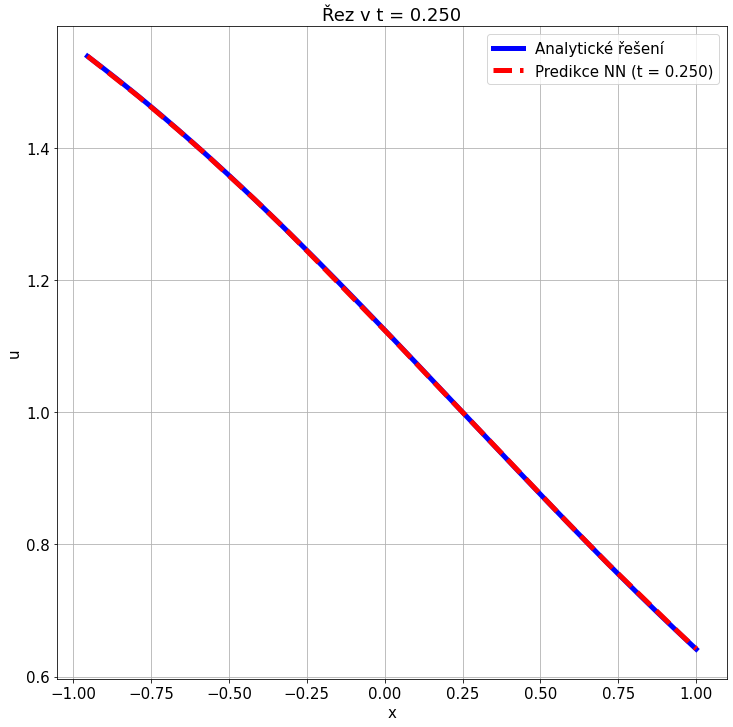

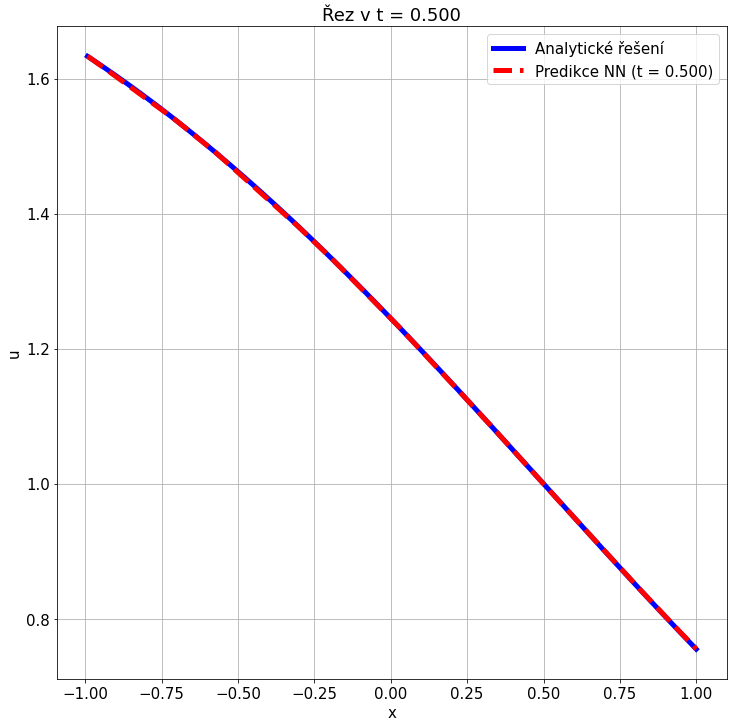

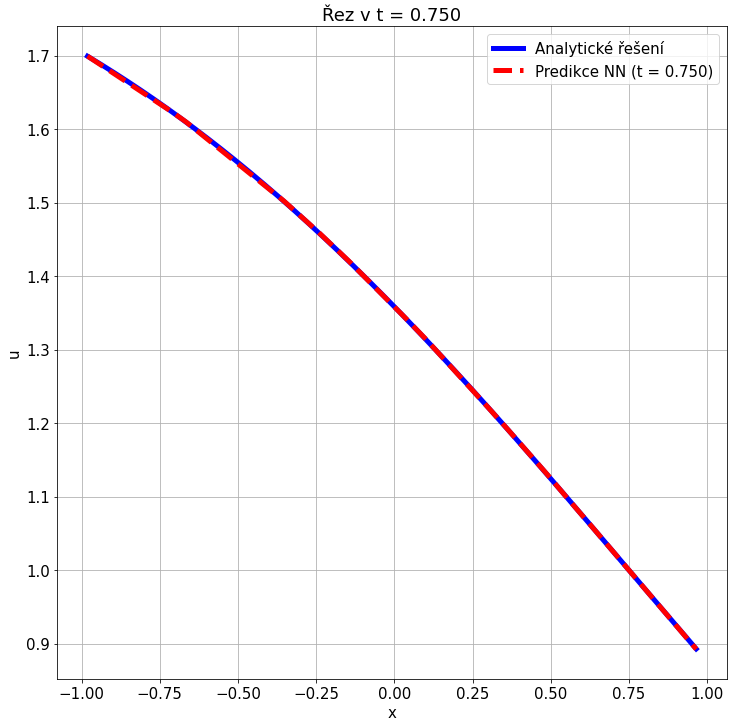

In [ ]:
# Krok 5.3: Vykreslení řezů přesného a aproximovaného řešení v t=0,25; t=0,5; t=0,75
plot_solution_cut_with_exact(0.25, t_test, x_test, u_pred)
plot_solution_cut_with_exact(0.5, t_test, x_test, u_pred)
plot_solution_cut_with_exact(0.75, t_test, x_test, u_pred)

In [272]:
# Krok 6.1: Výpočet relativní chyby aproximace řešení NN
if TYPE == "inviscid":
    true_values = exact_solution_inviscid(t_test, x_test)
elif TYPE == "viscous":
    true_values = exact_solution_viscous(t_test, x_test)

error_norm = torch.norm(u_pred - true_values)
true_norm = torch.norm(true_values)
relative_error = error_norm / true_norm
print(f'Relativní chyba úlohy: {relative_error.item():.6f}')

Relativní chyba úlohy: 0.000089


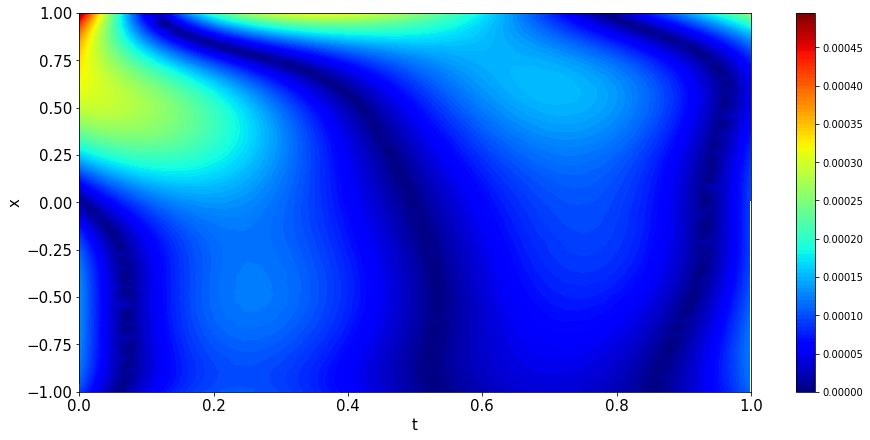

In [268]:
# Krok 6.2: Výpočet a vykreselní relativní pointwise chyby aproximace řešení NN
pointwise_relative_error = torch.abs((u_pred - true_values) / (true_values))

# Interpolace
fig, axes = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)

t = t_test.detach().cpu().numpy().squeeze()
x = x_test.detach().cpu().numpy().squeeze()
z = pointwise_relative_error.detach().cpu().numpy().squeeze()

grid_t, grid_x = np.linspace(0, 1, 500), np.linspace(-1, 1, 500)
grid_t, grid_x = np.meshgrid(grid_t, grid_x)
grid_z = griddata((t, x), z, (grid_t, grid_x), method="linear")

# Vykreslení
ax = axes
im = ax.contourf(grid_t, grid_x, grid_z, levels=100, cmap="jet", vmin=None, vmax=None)
cbar = fig.colorbar(im, ax=ax, orientation="vertical")
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("x", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()